**Author: Albers Uzila**

**This notebook contains sensitive data and not to be distributed.**

# Preface

This is a study case of utilizing GSTAR model to a real world data. First, import some libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from gstar.utils import make_weight_matrices
from gstar.model_identification import Stacf, Stpacf
from gstar.parameter_estimation import GSTAR

Code below is for settings in matplotlib.

In [2]:
import matplotlib.dates as mdates
import matplotlib.units as munits
import datetime

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (12,5)

# Read Dataset

The data used is the monthly tea production of six plantations in West Java, Indonesia, from January 1992 to December 2010. There are 6 plantation sites: Purbasari, Santosa, Sedep, Papandayan, Cisaruni, and Dayeuh Manggung, respectively labeled by `PUR`, `SAN`, `SED`, `PAP`, `CIS`, and `DAM`.

We are also given the Euclidean distance between each pair of sites.

In [3]:
df = pd.read_csv('tea.csv', parse_dates=['Time'], index_col=0)
dist = pd.read_csv('distance.csv', index_col=0)
display(df)
display(dist)

,PUR,SAN,SED,PAP,CIS,DAM
Time,,,,,,
1992-01-01,113.825404,96.885175,181.199280,-4.319517,-30.838846,-7.116422
1992-02-01,-10.090452,-37.674335,-28.629941,-4.897982,15.336154,66.029767
1992-03-01,72.821009,46.726702,78.587289,42.812051,57.583376,45.246961
1992-04-01,91.144055,62.585311,95.194841,21.962157,39.517636,91.095560
1992-05-01,76.631191,61.048924,86.275535,5.722454,37.531524,86.548112
...,...,...,...,...,...,...
2010-08-01,-64.351361,-51.518104,-35.326038,-23.871369,-57.755600,-39.826036
2010-09-01,-38.856963,-39.777284,-50.267008,-31.105999,-34.700964,-47.890639
2010-10-01,-67.074803,-69.863027,-70.443652,-32.437164,-40.753866,-20.176083


,PUR,SAN,SED,PAP,CIS,DAM
PUR,0.000,0.320,0.750,1.140,1.484,1.401
SAN,0.320,0.000,0.447,0.832,1.185,1.237
SED,0.750,0.447,0.000,0.391,0.738,0.943
PAP,1.140,0.832,0.391,0.000,0.364,0.901
CIS,1.484,1.185,0.738,0.364,0.000,0.863
DAM,1.401,1.237,0.943,0.901,0.863,0.000


We could plot the data as follows. It can be seen that it's already stationary with mean zero.

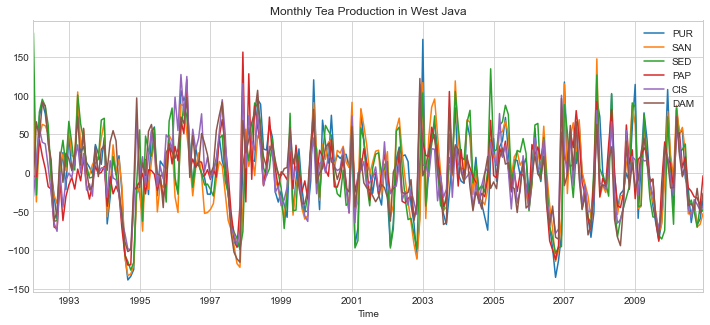

In [4]:
df.plot()
plt.title('Monthly Tea Production in West Java')
plt.legend(loc='upper right')
plt.show()

Let's see the stationarity for each location using ADF test. We see that all time series are stationary, indicated by p-value less than 0.05.

In [5]:
for col in df.columns:
    result = adfuller(df[col])
    print('p-value for %s: %f' % (col, result[1]))

p-value for PUR: 0.000198
p-value for SAN: 0.000298
p-value for SED: 0.006361
p-value for PAP: 0.000000
p-value for CIS: 0.000000
p-value for DAM: 0.000000


This is the pairwise distance between sites visualized in a heatmap. The largest distance is between `PUR` and `CIS`.

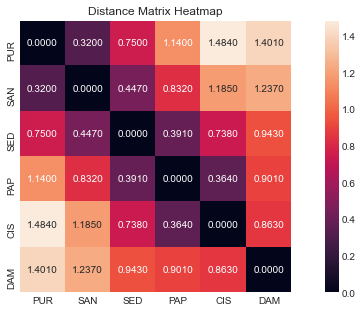

In [6]:
sns.heatmap(dist, annot=True, fmt='.4f', square=True)
plt.title('Distance Matrix Heatmap')
plt.show()

Next, save the dimension of the data, and split it into train and test. The dimension of train and test is shown below.

In [7]:
T,N = df.shape
test_size = 12
train = df[:-test_size]
test = df[-test_size:]
print(f'Train dataset shape {train.shape}')
print(f'Test dataset shape {test.shape}')

Train dataset shape (216, 6)
Test dataset shape (12, 6)


# Generate Weight Matrices

To a reference site, all site coordinates are divided into 4 spatial lags with a radius system:

* (0.0, 0.4] distance unit from the reference site is considered area with spatial lag 1.
* (0.4, 0.8] distance unit from the reference site is considered area with spatial lag 2.
* (0.8, 1.2] distance unit from the reference site is considered area with spatial lag 3.
* (1.2, 1.6] distance unit from the reference site is considered area with spatial lag 4.

In [8]:
max_s_lag = 4
grid = np.linspace(0.0, 1.6, max_s_lag+1)
grid

array([0. , 0.4, 0.8, 1.2, 1.6])

Given the spatial lags, generate weight matrices. For now, use `uniform` mode.

In [9]:
Ws = make_weight_matrices(dist, max_s_lag, grid, mode='uniform')

for i, W in enumerate(Ws):
    print(f'Spatial lag {i}:\n{W}\n')

Spatial lag 0:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

Spatial lag 1:
[[0.    1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.5   0.    0.5   0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.125 0.125 0.25  0.25  0.25  0.   ]]

Spatial lag 2:
[[0.         0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.         0.33333333 0.        ]
 [0.2        0.2        0.2        0.         0.2        0.2       ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.15384615 0.15384615 0.23076923 0.23076923 0.23076923 0.        ]]

Spatial lag 3:
[[0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.5        0.5        0.        ]
 [0.         0.       

# Modeling

## Model Identification

The first step in modeling is model identification. In this part, time and spatial orders such as $p, \lambda_1, \dots, \lambda_p$ will be determined using STACF and STPACF, which are visualized using the `plot()` function below.

In [10]:
def plot_acf(stacf, stpacf, ts_matrix, t_lag):
    m,n = stacf.shape
    mat_dict = {'STACF':stacf, 'STPACF':stpacf}
    bts = 1.96 / np.sqrt(len(ts_matrix))
    for key, val in mat_dict.items():
        fig, axs = plt.subplots(n, figsize=(10, 4*n))
        if n == 1: axs = [axs]
        fig.suptitle(key, size=20, x=0.0)
        xaxis = range(1, m+1)
        for i in range(n):
            axs[i].bar(xaxis, val[:,i])
            axs[i].axhline( bts, c='r', linestyle='--')
            axs[i].axhline(-bts, c='r', linestyle='--')
            axs[i].set_ylim((-1,1))
            axs[i].set_xlim(0)
            axs[i].set_title(f'Spatial Order {i}')
            axs[i].set_xticks(range(t_lag+1))
        plt.tight_layout()
        plt.show()

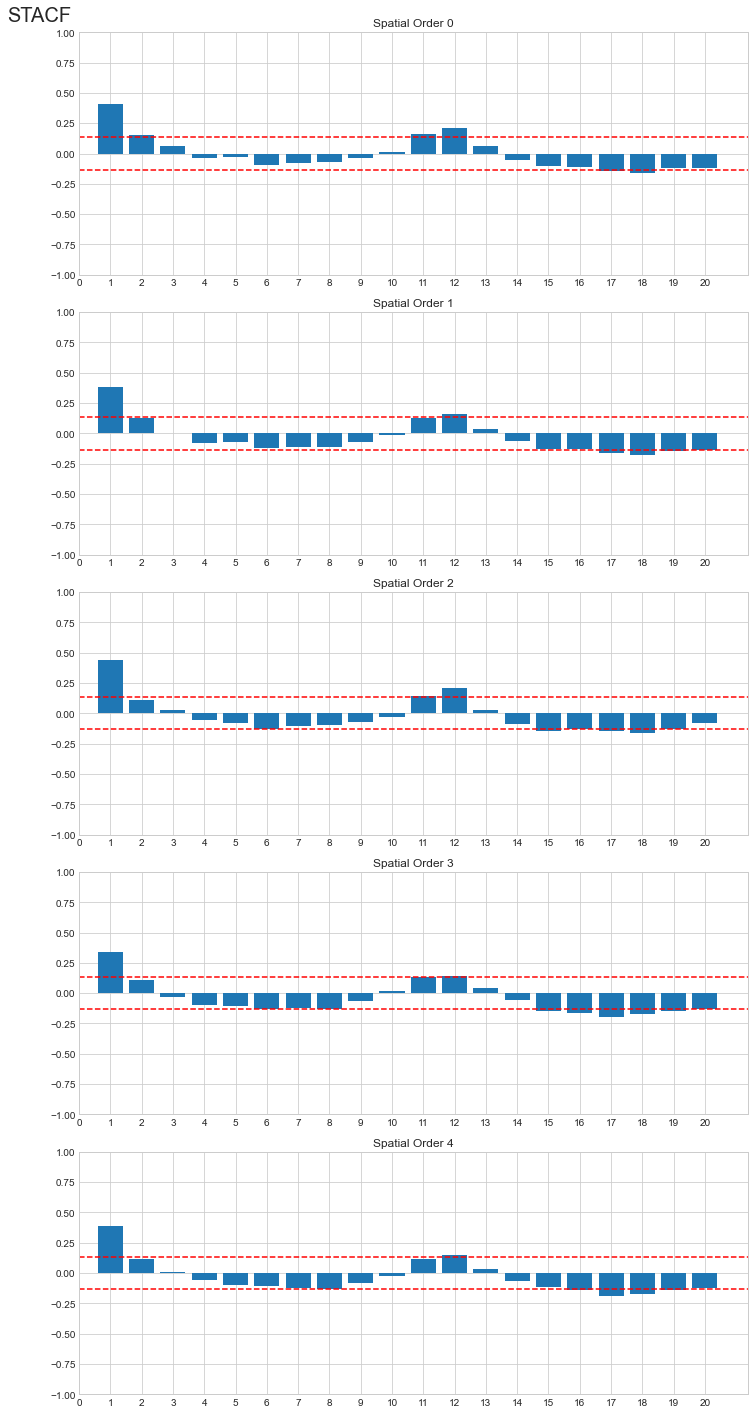

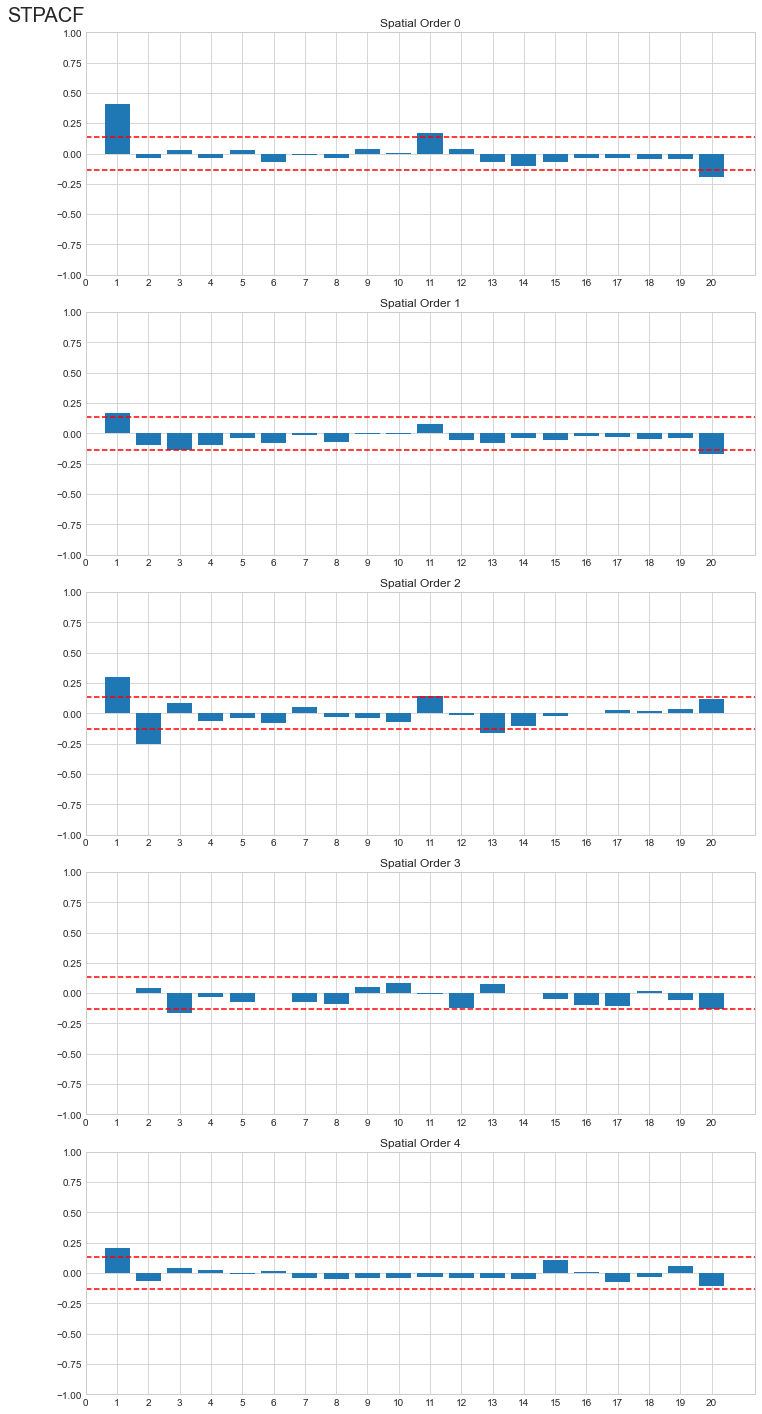

In [11]:
stacf = Stacf(train, Ws, 20).estimate()
stpacf = Stpacf(train, Ws, 20).estimate()
plot_acf(stacf, stpacf, train, 20)

STACF has a tail-off trend and STPACF has a cut-off trend: a good indication of GSTAR model usage. In particular, for time order 1, STPACF shows significance until spatial order 4, and for time order 2, STPACF shows significance at spatial order 2. No significane is shown starting time order 3. Below are the chosen orders with format ($p, [\lambda_1, \dots, \lambda_p]$).

In [12]:
orders = [
    (1, [0]), (1, [1]), (1, [2]), (1, [3]), (1, [4]),
    (2, [0,0]), (2, [0,1]), (2, [0,2]),
    (2, [1,0]), (2, [1,1]), (2, [1,2]),
    (2, [2,0]), (2, [2,1]), (2, [2,2]),
    (2, [3,0]), (2, [3,1]), (2, [3,2]),
    (2, [4,0]), (2, [4,1]), (2, [4,2]),
]

## Parameter Estimation

Next, estimate the parameters of the model, $\Phi_{kl}$. We will also check the stationarity of the GSTAR process on the fly, using the method of Inverse of Autocovariance Matrix (IMAk).

Run through the selected `orders` and tabulate the results. The results include $p$, $\lambda_k$, MSR of fitted to train data, AIC, determinants of the leading principal submatrices of IMAk, stationarity of the process, residual, and parameter $B$.

As can be seen below, GSTAR(2, [3, 0]) is the best model which is stationary and has the lowest AIC.

In [13]:
result = []
for p, lambd in orders:
    model = GSTAR(Ws, p, lambd)
    fitted = model.fit(train)
    result.append(model.result)

result = pd.DataFrame(result)
result = result.sort_values(['stationary', 'AIC'], ascending=[False, True]).reset_index(drop=True)
result

,p,lambda,MSR,AIC,determinants,stationary,residual,parameter
0,2,"[3, 0]",1676.890414,10.309302,"[0.9948306344243837, 0.9948101768424298, 0.977...",True,"[[89.08614201167921, 56.917456390955465, 72.55...","[[0.01845235927561228], [0.07874603842271347],..."
1,2,"[3, 1]",1664.028173,10.310948,"[0.983209928822537, 0.9623818998532387, 0.9398...",True,"[[90.06380625091289, 59.07803125986331, 73.843...","[[-0.0007454643538880355], [0.1073684081638837..."
2,1,[3],1696.002099,10.311115,"[0.8997345511948015, 0.562974554663673, 0.5137...",True,"[[-21.09726988075048, -18.012749810780072, -48...","[[-0.01819294088749118], [0.0985611231769749],..."
3,2,"[3, 2]",1650.076357,10.311874,"[0.9556704519443419, 0.9009304156070558, 0.878...",True,"[[83.59215459040087, 58.20381737378639, 65.182...","[[-0.009486993895223079], [0.1422411885827975]..."
4,2,"[1, 2]",1826.159234,10.394576,"[0.9364311166556077, 0.843235666503579, 0.7705...",True,"[[80.32964378849002, 67.21723137783493, 101.10...","[[0.22691894342509625], [0.27646329678821063],..."
5,2,"[1, 0]",1864.186621,10.396495,"[0.9884921307149668, 0.9852185944750907, 0.969...",True,"[[95.286208905434, 72.05393372960343, 112.5873...","[[0.3033656629113012], [0.1909393451409971], [..."
6,2,"[1, 1]",1850.276140,10.398350,"[0.9813168462938181, 0.9650125823724295, 0.948...",True,"[[96.64741195025277, 74.26089167986916, 111.46...","[[0.2750838459700206], [0.23074555861762305], ..."
7,1,[1],1890.377596,10.401014,"[0.9274278764137741, 0.6263351236278436, 0.592...",True,"[[-56.77419476137577, -75.62502970315441, -67....","[[0.24064456489710084], [0.19912517903675897],..."
8,2,"[2, 0]",1855.841265,10.401354,"[0.9867411788118547, 0.9836069860145185, 0.968...",True,"[[96.50437606207858, 71.86984842763897, 111.95...","[[0.25948625717250917], [0.09626938132766136],..."
9,2,"[2, 2]",1822.034216,10.401661,"[0.9390455136305326, 0.858628656686423, 0.7971...",True,"[[83.58151861940718, 65.23035640623162, 97.876...","[[0.20789343746582617], [0.211334462235185], [..."


## Diagnostic Checking

The last step in modeling is to do diagnostic checking, which is to check whether the residual is random, stationary, and normally distributed. This can be done by plotting residual vs time, using boxplot of residual, or utilizing Q-Q normal plot. We can see below that all these assumptions are satisfied.

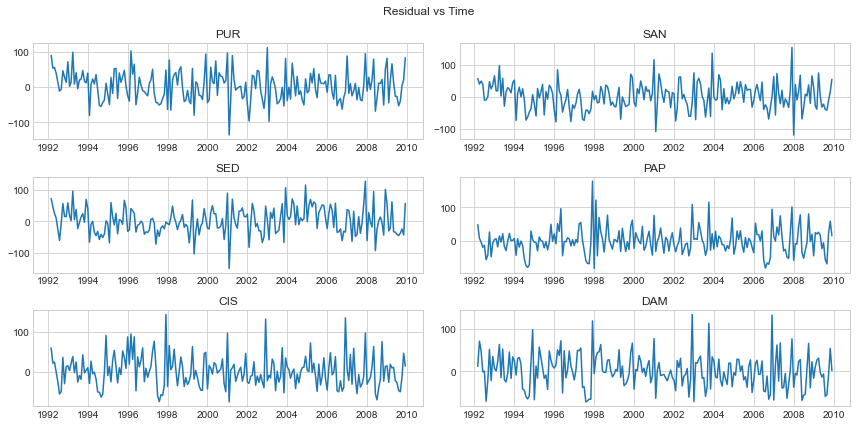

In [14]:
best_res = result['residual'][0]
best_res = pd.DataFrame(best_res, columns=fitted.columns, index=fitted.index)
fig, axs = plt.subplots(3, 2, figsize=(12,6))

for i, col in enumerate(best_res.columns):
    ax = axs[i//2, i%2]
    ax.plot(best_res[col])
    ax.set_title(col)

plt.suptitle('Residual vs Time')
plt.tight_layout()
plt.show()

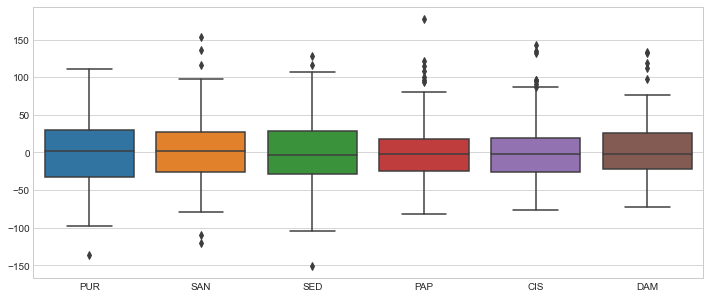

In [15]:
sns.boxplot(data=best_res);

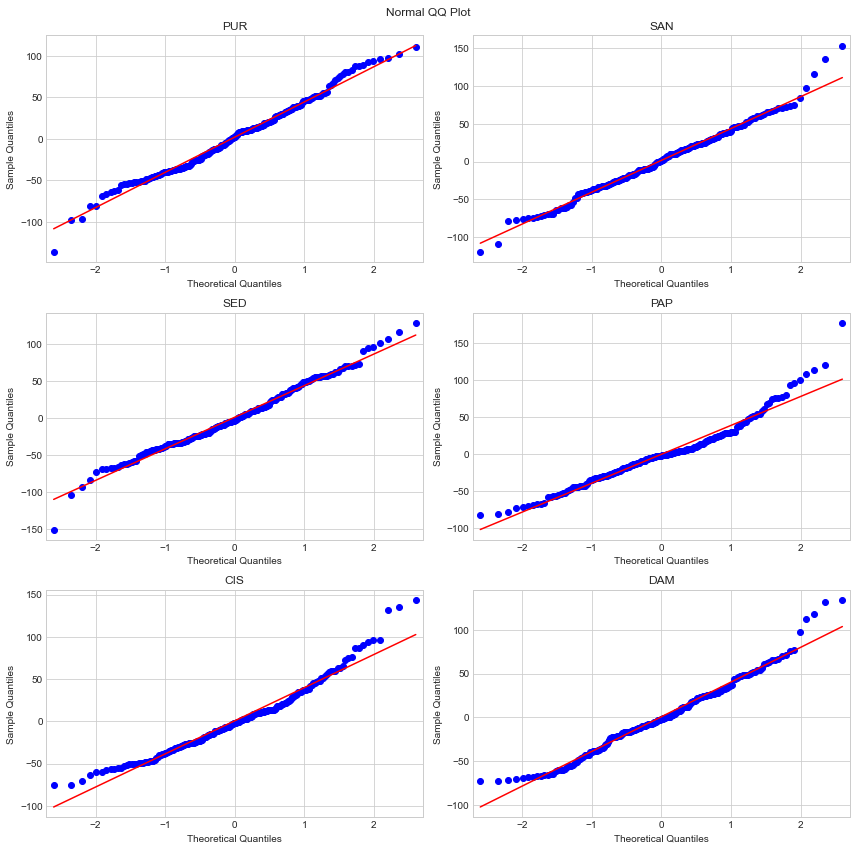

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(12,12))

for i, col in enumerate(best_res.columns):
    ax = axs[i//2, i%2]
    sm.qqplot(best_res[col], line='s', ax=ax)
    ax.set_title(col)

plt.suptitle('Normal QQ Plot')
plt.tight_layout()
plt.show()

# Forecasting

Now test our model on unseen data. First off, pick the best $p$ and $\lambda$, and its associated parameter $B$.

In [17]:
p = result['p'][0]
lambd = result['lambda'][0]
B = result['parameter'][0]

Forecasting time! We will try several scenarios:

1. Newcoming data is immediately used for forecasting the next timestep
2. Long forecast for several timesteps without using newly received data

## Immediate Update

In [18]:
forecast = model.forecast(len(test), test)

Here's the MSR of forecast to test data.

In [19]:
msr, _ = model.score(forecast.values, test.values, B)
msr

1283.565010879702

We can plot train and test data as well as fitted and forecasted values as follows.

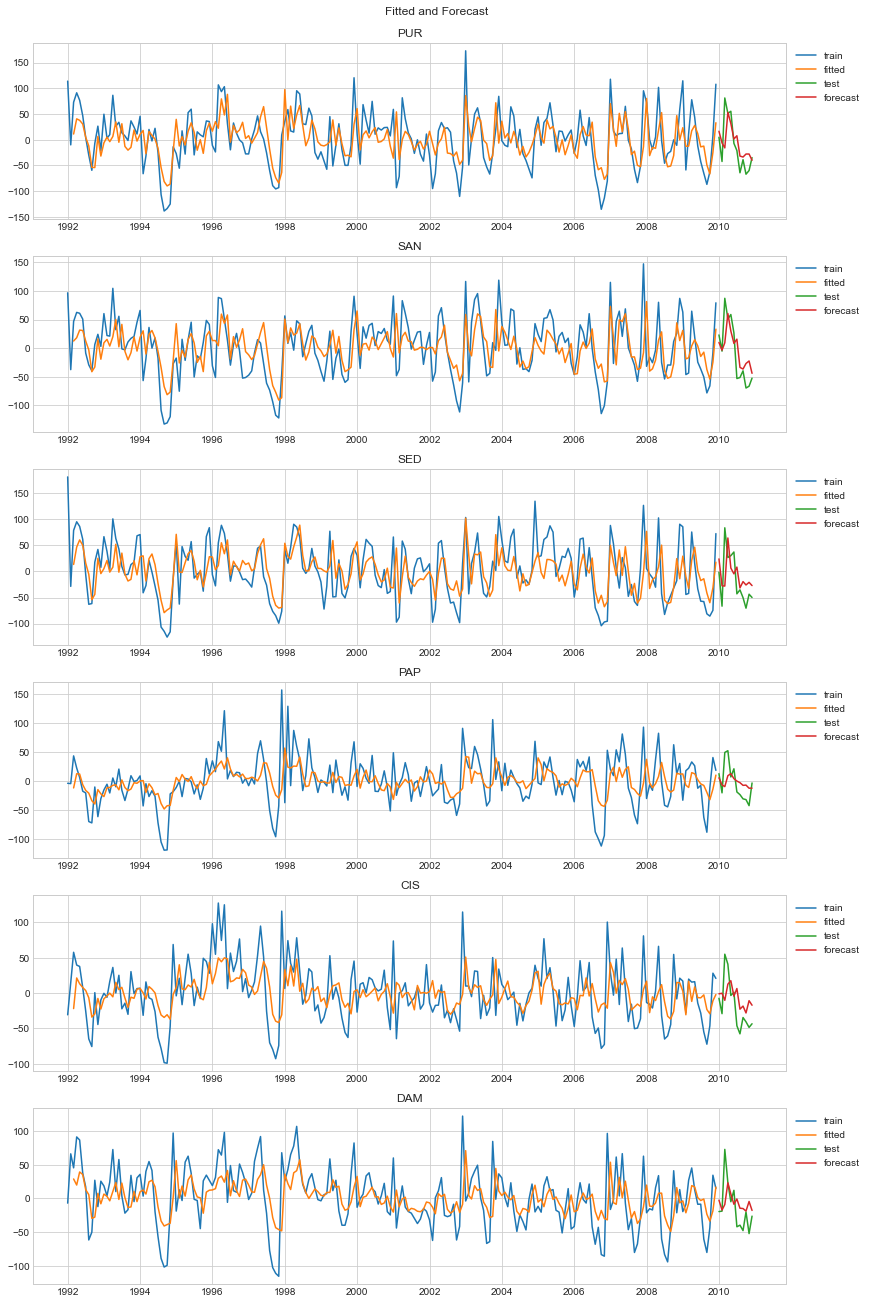

In [20]:
fig, axs = plt.subplots(6, 1, figsize=(12, 18), constrained_layout=True)
cols = test.columns
for col, ax in zip(cols, axs):
    ax.plot(train[col], label='train')
    ax.plot(fitted[col], label='fitted')
    ax.plot(test[col], label='test')
    ax.plot(forecast[col], label='forecast')
    ax.legend(loc='upper right', bbox_to_anchor=(1.11, 1))
    ax.set_title(col)

plt.suptitle('Fitted and Forecast')
plt.show()

## Long Forecast

In [21]:
long_forecast = model.forecast(len(test))
long_forecast.index = test.index
long_forecast.columns = test.columns

Here's the MSR of forecast to test data.

In [22]:
msr, _ = model.score(long_forecast.values, test.values, B)
msr

1987.1612886364096

We can plot train and test data as well as fitted and forecasted values as follows.

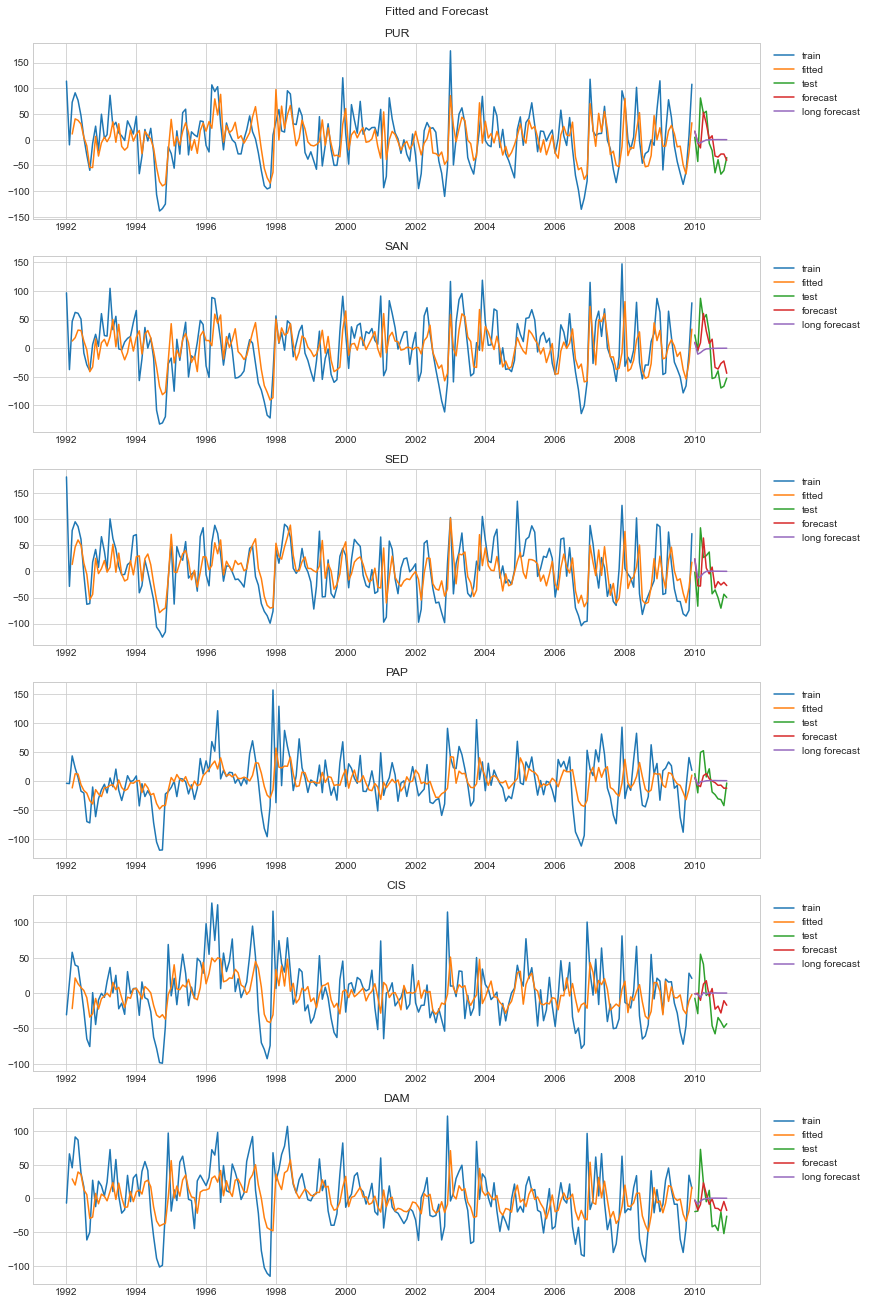

In [23]:
fig, axs = plt.subplots(6, 1, figsize=(12, 18), constrained_layout=True)
cols = test.columns
for col, ax in zip(cols, axs):
    ax.plot(train[col], label='train')
    ax.plot(fitted[col], label='fitted')
    ax.plot(test[col], label='test')
    ax.plot(forecast[col], label='forecast')
    ax.plot(long_forecast[col], label='long forecast')
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    ax.set_title(col)

plt.suptitle('Fitted and Forecast')
plt.show()

* Grafik
* Forecast memanfaatkan variansi dari residual sebelumnya
* Crier
* Prediction Limit